In [1]:
import keras
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import concatenate, Lambda, Reshape
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import keras.backend as K
from keras.datasets import cifar10
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import itertools
import numpy as np
import os
import copy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import pydot
from IPython.display import SVG

In [2]:
def getimages(direct):
    im=[]
    label=[]
    lab=0
    for labels in os.listdir(direct):
        #Label corresponding to folder
        if labels=="buildings":
            lab=0
        if labels=="forest":
            lab=1
        if labels=="glacier":
            lab=2
        if labels=="mountain":
            lab=3
        if labels=="sea":
            lab=4
        if labels=="street":
            lab=5
        for image in os.listdir(direct+r'/'+labels):
            #Read images
            imag=cv2.imread(direct+r'/'+labels+r'/'+image)
            imag=cv2.resize(imag,(150,150))
            
            im.append(imag)
            label.append(lab)
    #Suffle all images
    return shuffle(im, label)

#Obtain both train and test images
im,label=getimages("archive\seg_train\seg_train")      
im1,label1=getimages("archive\seg_test\seg_test") 
img=im+im1
lab=label+label1

#Convert to numpy array
Images=np.array(img)
Labels=np.array(lab)

classes=6

In [3]:
nat = [i for i in range(len(Labels)) if Labels[i] in [2,3,4]]
Images_nat=Images[nat]
Labels_nat=Labels[nat]

In [4]:
#Split into train, validation and test
x1, xtest, y1,ytest=train_test_split(Images_nat, Labels_nat, random_state=0)
xtrain, xvalidation, ytrain, yvalidation=train_test_split(x1, y1, random_state=0)

#Prepare x
xtrain = xtrain.astype('float32')
xvalidation = xvalidation.astype('float32')
xtest=xtest.astype('float32')
xtrain /= 255
xvalidation /= 255
xtest /= 255


In [5]:
ytrainnat1=np.array([0 if i in [2] else 1 if i in [3] else 2 for i in ytrain])
yvalnat1=np.array([0 if i in [2] else 1 if i in [3] else 2 for i in yvalidation])
ytestnat1=np.array([0 if i in [2] else 1 if i in [3] else 2 for i in ytest])
ytrainnat = keras.utils.to_categorical(ytrainnat1, 3)
ytestnat = keras.utils.to_categorical(ytestnat1, 3)
yvalnat = keras.utils.to_categorical(yvalnat1, 3)

In [6]:
# Small VGG-like model
def simpleVGG(im_Input, num_classes, name="vgg"):
    name = [name+str(i) for i in range(12)]
    
    # convolution and max pooling layers
    vgg = Conv2D(32, (3, 3), padding='same', activation='relu', name=name[0])(im_Input)
    vgg = Conv2D(32, (3, 3), padding='same', activation='relu', name=name[1])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[2])(vgg)
    vgg = Dropout(0.25, name=name[3])(vgg)
    vgg = Conv2D(64, (3, 3), padding='same', activation='relu', name=name[4])(vgg)
    vgg = Conv2D(64, (3, 3), padding='same', activation='relu', name=name[5])(vgg)
    vgg = MaxPooling2D(pool_size=(2,2), name=name[6])(vgg)
    vgg = Dropout(0.25, name=name[7])(vgg)

    # classification layers
    vgg = Flatten(name=name[8])(vgg)
    vgg = Dense(512, activation='relu', name=name[9])(vgg)
    vgg = Dropout(0.5, name=name[10])(vgg)
    vgg = Dense(num_classes, activation='softmax', name=name[11])(vgg)
    return vgg

In [10]:
im_Input = Input(shape=(xtrain.shape[1:]), name="input")
baseVGG = simpleVGG(im_Input, 3, "base")
natModel = Model(im_Input, baseVGG)

In [11]:

# compile
natModel.compile(loss='categorical_crossentropy',
                   optimizer=Adam(),
                   metrics=['accuracy'])

In [13]:
# get the newest model file within a directory
def getNewestModel(model, dirname):
    from glob import glob
    target = os.path.join(dirname, '*')
    files = [(f, os.path.getmtime(f)) for f in glob(target)]
    if len(files) == 0:
        return model
    else:
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        model.load_weights(newestModel[0])
        return model
    
# make saving directory for checkpoints
baseSaveDir = "./nat_Im/"
if not os.path.isdir(baseSaveDir):
    os.makedirs(baseSaveDir)
    
# early stopping and model checkpoint
es_cb = EarlyStopping(monitor='loss', patience=2, verbose=1, mode='auto')
chkpt = os.path.join(baseSaveDir, 'nat.{epoch:02d}-{val_loss:.2f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

# load the newest model data from the directory if exists
natModel = getNewestModel(natModel, baseSaveDir)

In [12]:
# Number of training/testing examples per batch
batch_size = 50

# Training epochs. A higher number of epochs corresponds to "more fitting to training data"
epochs = 10

# train
history=natModel.fit(xtrain, ytrainnat,
               batch_size=batch_size,
               epochs=epochs,
               validation_data=(xvalidation, yvalnat),
               callbacks=[es_cb,cp_cb])

Epoch 1/10
99/99 [==============================] - ETA: 0s - loss: 1.2259 - accuracy: 0.4600
Epoch 00001: val_loss improved from inf to 0.96738, saving model to ./nat_Im\nat.01-0.97.hdf5
99/99 [==============================] - 244s 2s/step - loss: 1.2259 - accuracy: 0.4600 - val_loss: 0.9674 - val_accuracy: 0.5128
Epoch 2/10
46/99 [============>.................] - ETA: 1:56 - loss: 0.9252 - accuracy: 0.5735

KeyboardInterrupt: 

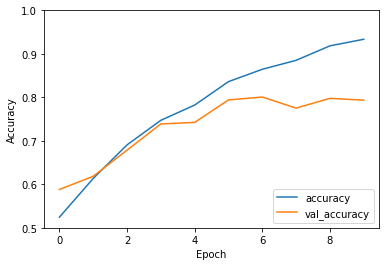

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [28]:
y_pred = natModel.predict(xtrain)
matrix = confusion_matrix(ytrainnat.argmax(axis=1), y_pred.argmax(axis=1))

In [29]:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.Blues):
 
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
         print("Confusion matrix, without normalization")
 
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label") 

Normalized confusion matrix


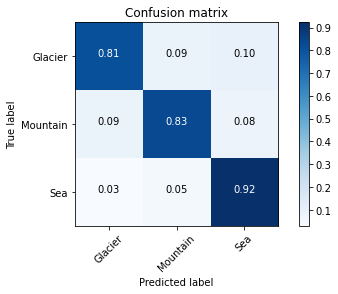

In [30]:
plot_confusion_matrix(matrix, ["Glacier", "Mountain", "Sea"], normalize=True)

In [19]:
weights, biases = natModel.layers[10].get_weights()